In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, merge, Convolution3D,Conv3D, MaxPooling3D, UpSampling2D,BatchNormalization,Activation,Dense,Dropout,Flatten
from keras.optimizers import Adam,SGD
from keras import backend as K
K.set_image_dim_ordering('th') 
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential, Model
from sklearn.model_selection import KFold

Using TensorFlow backend.


## Add labels

In [20]:
dataDirectory = '../unlabelled_segment/'
lungPatients = os.listdir(dataDirectory)
labels = pd.read_csv('/home/usma/Downloads/stage1_solution.csv', index_col=0)
size = 50
NoSlices = 40

In [21]:
def dataProcessing(patient, labels_df, size, noslices=40, visualize=False):
    
    label = labels_df.at[patient[:-4], 'cancer']
    path = dataDirectory + patient
    slices = np.load(path)
#     print(slices.shape)
#     slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(each_slice, (size, size)) for each_slice in slices]
#     print(len(slices))

    if label == 1:
        label = np.array([0, 1])
    elif label == 0:
        label = np.array([1, 0])
    return np.array(slices),label



In [ ]:
count=0
imageData = []
for num, patient in enumerate(lungPatients):
    if num % 10 == 0:
        print('Saved -', num)
    try:
        img_data, label = dataProcessing(patient, labels, size=size, noslices=NoSlices)
        imageData.append([img_data, label,patient])
    except KeyError as e:
        print('Data is unlabeled')
        count=count+1
print(count)

## Load files

In [25]:
# file1 = np.load("/media/usma/New Volume/usma_10_05_2018/abhishek/Kaggle_lung_segmentation.npy")
file2 = np.load("/home/usma/Desktop/Research_Project/practical/Myproject/DataFiles/imageDataNew-50-50-20.npy")
file3 =  np.load("/media/usma/New Volume/usma_10_05_2018/abhishek/direct_kaggle_unlabelled-20-50-50.npy")

In [26]:
file3[0][0].shape

(20, 50, 50)

In [27]:
# print(file1.shape)
print(file2.shape)
print(file3.shape)

(1397, 3)
(198, 3)


In [4]:
file2[0]

array([ array([[[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ..., 
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],

       [[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ..., 
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],

       [[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ..., 
 

## Resample and normalize data

In [28]:
img_rows=50
img_cols=50
depth=20
num_classes=2

In [52]:
np.random.shuffle(file2)

In [53]:
def resample(f):
    resample_array=np.zeros((depth,img_rows,img_cols))
    for i in range(len(f)):
        resample_array[i,:,:]=f[i]
    return resample_array

In [31]:
# newdata1=np.zeros((len(file1),depth,img_rows,img_cols))
# newlabel1=np.zeros((len(file1),2))
# for i in range(len(file1)):
#     newdata1[i,:,:,:]=resample(file1[i][0])
#     newlabel1[i,:]=(file1[i][1])

In [54]:
newdata2=np.zeros((len(file2),depth,img_rows,img_cols))
newlabel2=np.zeros((len(file2),2))
for i in range(len(file2)):
    newdata2[i,:,:,:]=resample(file2[i][0])
    newlabel2[i,:]=(file2[i][1])

In [33]:
newdata3=np.zeros((len(file3),depth,img_rows,img_cols))
newlabel3=np.zeros((len(file3),2))
for i in range(len(file3)):
    newdata3[i,:,:,:]=resample(file3[i][0])
    newlabel3[i,:]=(file3[i][1])

In [34]:
# print("Kaggle_segmented_data: ",newdata1.shape)
# print("Kaggle_segmented_label: ",newlabel1.shape)

print("Kaggle_NSC_segmented_data: ",newdata2.shape)
print("Kaggle_NSC_segmented_label: ",newlabel2.shape)

print("Unlabelled_data: ",newdata3.shape)
print("unlabelled_segmented_label: ",newlabel3.shape)

Kaggle_NSC_segmented_data:  (1397, 20, 50, 50)
Kaggle_NSC_segmented_label:  (1397, 2)
Unlabelled_data:  (198, 20, 50, 50)
unlabelled_segmented_label:  (198, 2)


In [54]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
image = (newdata1 - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
image[image>1] = 1.
image[image<0] = 0.
image = image - PIXEL_MEAN
data1=image[:,np.newaxis,:,:];
print(data1.shape)

(1759, 1, 40, 50, 50)


In [36]:
print(newdata1.min())
print(newdata1.max())

-2048.0
1986.93756003


In [53]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
image = (newdata2 - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
image[image>1] = 1.
image[image<0] = 0.
image = image - PIXEL_MEAN
data2=image[:,np.newaxis,:,:];
print(data2.shape)

In [35]:
data3=newdata3[:,np.newaxis,:,:];######### Test data

In [55]:
data2=newdata2[:,np.newaxis,:,:];

In [ ]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
image = (newdata3 - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
image[image>1] = 1.
image[image<0] = 0.
image = image - PIXEL_MEAN
data3=image[:,np.newaxis,:,:];
print(data3.shape)

In [17]:
import gc
del newdata3
# del newlabel3
del file3
del newdata2
del file2
# del newdata1
# del file1
gc.collect()


174

In [37]:
# X_T=data3
# Y_T=newlabel3    ####### with normalisation


X_H = data3       ########## without normalization
Y_H = newlabel3

In [38]:
print(X_H.shape)

(198, 1, 20, 50, 50)


In [39]:
print(Y_H.shape)

(198, 2)


In [40]:
def plot(b):
    plt.figure(figsize=(13,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'][:b+2], marker='.')
    plt.plot(history.history['val_loss'][:b+2], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss', 'val_loss'], loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(history.history['acc'][:b+2], marker='.')
    plt.plot(history.history['val_acc'][:b+2], marker='.')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['acc', 'val_acc'], loc='lower right')

# Model 1

In [41]:
model = Sequential()

model.add(Convolution3D(32, 3, 3, 3, activation='relu', border_mode='same', input_shape=(1,depth, img_rows,img_cols)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Convolution3D(64, 3, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Convolution3D(128, 3, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), border_mode='same'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

optim = Adam(lr=.001)
model.compile(optimizer=optim, loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 32, 20, 50, 50)    896       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 32, 10, 25, 25)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 10, 25, 25)    128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 10, 25, 25)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 64, 10, 25, 25)    55360     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 64, 5, 13, 13)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 5, 13, 13)     256       
__________

In [50]:
np.random.shuffle(data2)

## K FOLD FOR KAGGLE 

Train on 1047 samples, validate on 350 samples
Epoch 1/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.5313 - acc: 0.7531 - val_loss: 0.5251 - val_acc: 0.7314
Epoch 2/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.4985 - acc: 0.7598 - val_loss: 0.4872 - val_acc: 0.7529
Epoch 3/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.4668 - acc: 0.7884 - val_loss: 0.5324 - val_acc: 0.7371
Epoch 4/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.4625 - acc: 0.7865 - val_loss: 0.4678 - val_acc: 0.7857
Epoch 5/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.4402 - acc: 0.8018 - val_loss: 0.4453 - val_acc: 0.8200
Epoch 6/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.4378 - acc: 0.8013 - val_loss: 0.4522 - val_acc: 0.8171
Epoch 7/10
1047/1047 [==============================] - 6s 6ms/step - loss: 0.4224 - acc: 0.8104 - val_loss: 0.4496 - val_acc: 0.8200
Epoch 8/10
1047

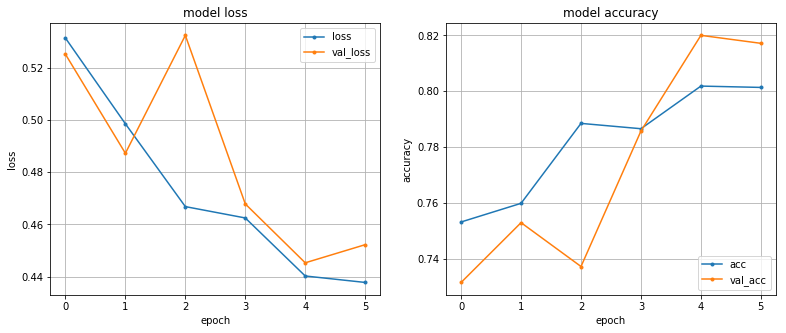

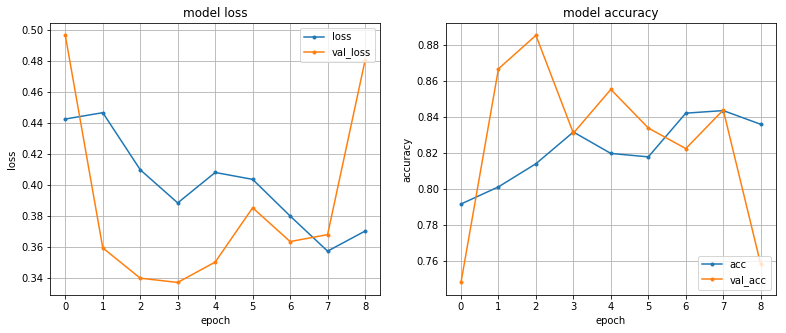

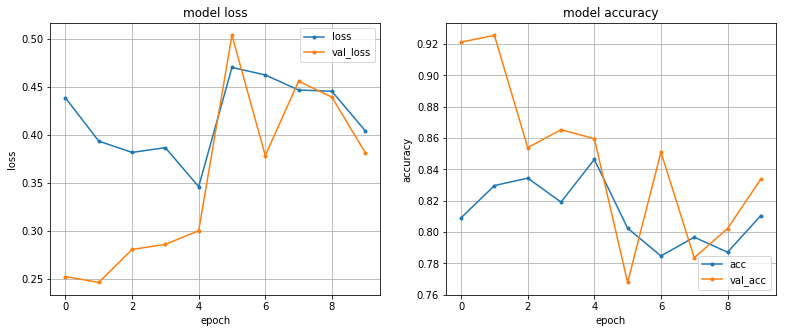

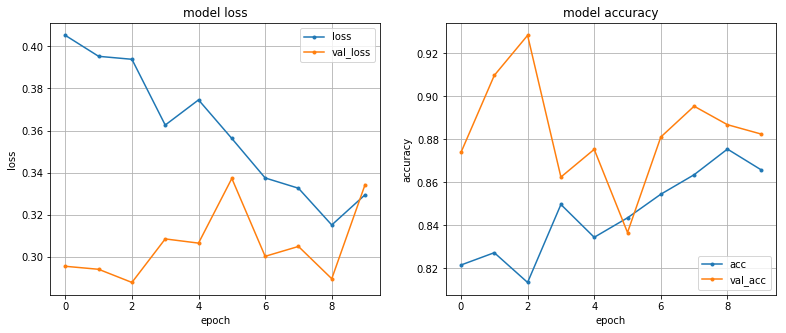

In [56]:
X = data2
Y = newlabel2
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=10,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [ ]:
del data1
del newlabel1
del data2
del newlabel2
del data3
del newlabel3
gc.collect()

In [48]:
loss,acc=model.evaluate(X_H,Y_H)

198/198 [==============================] - 0s 2ms/step


In [49]:
print(loss)
print(acc)

0.650709487573
0.719696969095


# MODEL 2

In [61]:
model = Sequential()
model.add(BatchNormalization(input_shape=[1,20,50,50]))
model.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))

model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))#layer1
model.add(BatchNormalization(axis=1))
# model.add(Dropout(0.5))

model.add(Conv3D(64, kernel_size=(3, 3, 3),  padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same') )#layer2
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same')) #layer3
model.add(BatchNormalization(axis=1))
model.add(Dropout(0.5)) 

model.add(Conv3D(256, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same')) #layer4
model.add(BatchNormalization(axis=1))

model.add(Dropout(0.5))    

model.add(Conv3D(512, kernel_size=(3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same')) #layer5
model.add(BatchNormalization(axis=1))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=.001), metrics=['accuracy'])

##  K FOLD for KAGGLE 

Train on 1047 samples, validate on 350 samples
Epoch 1/15
1047/1047 [==============================] - 5s 5ms/step - loss: 0.6199 - acc: 0.7192 - val_loss: 0.5621 - val_acc: 0.7343
Epoch 2/15
1047/1047 [==============================] - 5s 4ms/step - loss: 0.5932 - acc: 0.7192 - val_loss: 0.7206 - val_acc: 0.4771
Epoch 3/15
1047/1047 [==============================] - 5s 4ms/step - loss: 0.6137 - acc: 0.7154 - val_loss: 0.5883 - val_acc: 0.7314
Epoch 4/15
1047/1047 [==============================] - 5s 4ms/step - loss: 0.6081 - acc: 0.7163 - val_loss: 0.6102 - val_acc: 0.7286
Epoch 5/15
1047/1047 [==============================] - 5s 4ms/step - loss: 0.6147 - acc: 0.7297 - val_loss: 0.6109 - val_acc: 0.7314
Epoch 6/15
1047/1047 [==============================] - 5s 4ms/step - loss: 0.6061 - acc: 0.7192 - val_loss: 0.6059 - val_acc: 0.6714
Epoch 7/15
1047/1047 [==============================] - 5s 4ms/step - loss: 0.5989 - acc: 0.7221 - val_loss: 0.7094 - val_acc: 0.6600
Epoch 8/15
1047

1048/1048 [==============================] - 5s 5ms/step - loss: 0.3994 - acc: 0.8349 - val_loss: 0.9108 - val_acc: 0.7307
Validation Loss:  [0.60594064882823395, 0.59044397611672694, 0.52740325055013071, 0.49759420214546446]  Validation accuracy:  [0.67142857006617951, 0.76217765111294722, 0.77650430021449968, 0.74785100047431219]
Average Validation Loss:  0.55534551941
Average Validation Accuracy:  0.739490380467


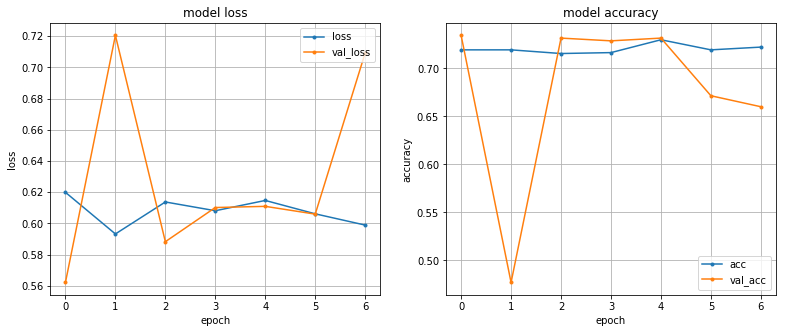

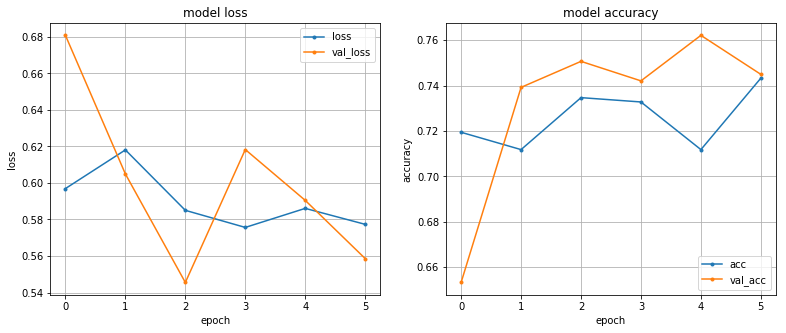

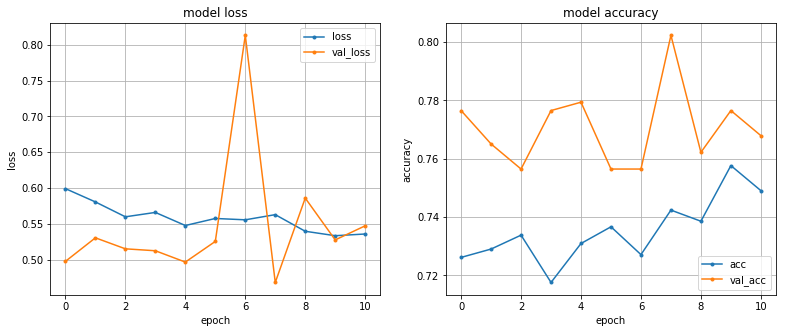

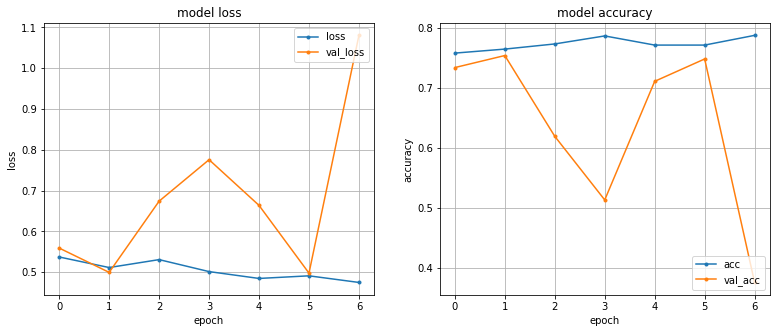

In [65]:
X = data2
Y = newlabel2
kf = KFold(n_splits=4)
kf.get_n_splits(X)
val_l = []
val_a = []
2
# print(kf)  
# KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    history=model.fit(X_train, Y_train,epochs=15,validation_data=(X_test, Y_test),batch_size=32)
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
#     print('epoch=%d' % int(bbb+1), history.history['loss'][bbb], history.history['val_loss'][bbb])
    bbb = np.argmin(np.abs(np.array(history.history['loss'])-np.array(history.history['val_loss'])))
    plot(bbb)
    val_l.append(history.history['val_loss'][bbb])
    val_a.append(history.history['val_acc'][bbb])
    
print("=====================")     
print("=====================") 
print("Validation Loss: ", val_l, " Validation accuracy: ", val_a)
print("Average Validation Loss: ", np.mean(np.array(val_l)))
print("Average Validation Accuracy: ", np.mean(np.array(val_a)))

In [63]:
loss,acc=model.evaluate(X_H,Y_H)

198/198 [==============================] - 0s 2ms/step


In [64]:
print(loss,acc)

0.651615263537 0.69696969697


In [25]:
# serialize model to JSON
model_json = model.to_json()
modelFileName = "K_Fold_KBS_NSC_without_norm"
with open(modelFileName + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(modelFileName + ".h5")
print("Saved model to disk")

Saved model to disk
